Basic sequencing
================

.. Note::
        A version of this tutorial suitable for RF modules can be found [here](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/tutorials/q1asm_tutorials/basic/rf/basic_sequencing.html).

In this tutorial we will demonstrate basic sequencer based operations (see [Sequencer Operation](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#operation)) for programming a qblox instrument.
This includes creating a sequence consisting of waveforms and a simple Q1ASM program,
and executing this sequence synchronously on multiple sequencers.

The general process for setting up and executing a program on a Q1 sequencer is as follows:

1. Connect to instrument
2. Prepare a sequence (JSON formatted file) which consists of
    - Waveforms for playback
    - Weights for weighted integration
    - Acquisitions for capture
    - Q1ASM program to be executed by the sequencer
3. This sequence is then loaded onto a sequencer on the connected instrument using the method `instrument_variable.sequencerX.sequence("SequenceFile.json")`
4. The sequencer is then setup over its API as necessary
5. Sequencer is then armed and started to commence the experiment
6. Stop the sequencer and close down all instruments

This tutorial will give a basic introduction on how to work with the waveforms and Q1ASM segments of a sequence.

In the Tutorial the sequence is going to consecutively play two waveforms, a gaussian and block with a duration of 20ns each, with an increasing wait period
in between them. We will increase the wait period by 20ns repeated 100 times, after which the sequence is stopped. The sequence will also trigger marker
output 1 at every interval, so that the sequence can be easily monitored on an oscilloscope.

We can perform this tutorial with either a Cluster QCM/QRM . We use the term 'QxM' encompassing both QCM and QRM modules.

Setup
-----

First, we are going to import the required packages.

In [1]:
from __future__ import annotations

import contextlib
import json
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.qcm_qrm import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

No devices found


In [3]:
cluster_ip = "192.0.2.72"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [5]:
# Close the chosen QCodes instrument to prevent name clash
with contextlib.suppress(KeyError):
    Cluster.find_instrument(cluster_name).close()

cluster = Cluster(
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg={
        2: ClusterType.CLUSTER_QCM,
        4: ClusterType.CLUSTER_QRM,
        6: ClusterType.CLUSTER_QCM_RF,
        8: ClusterType.CLUSTER_QRM_RF,
    }
    if cluster_ip is None
    else None,
)

#### Get connected modules

In [6]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [8]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qcm_type and not mod.is_rf_type)
modules

{14: <QcmQrm: cluster0_module14 of Cluster: cluster0>}

In [11]:
module = modules[14]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [12]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence. The waveforms constructed here will be referenced by the Q1ASM program for playback. See section [Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#sequences) for details on how waveform dictionary is structured.

Waveform resolution notes

In [13]:
# Waveform parameters
waveform_length = 22  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),
        "index": 0,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 1},
}

Let's plot the waveforms to see what we have created.

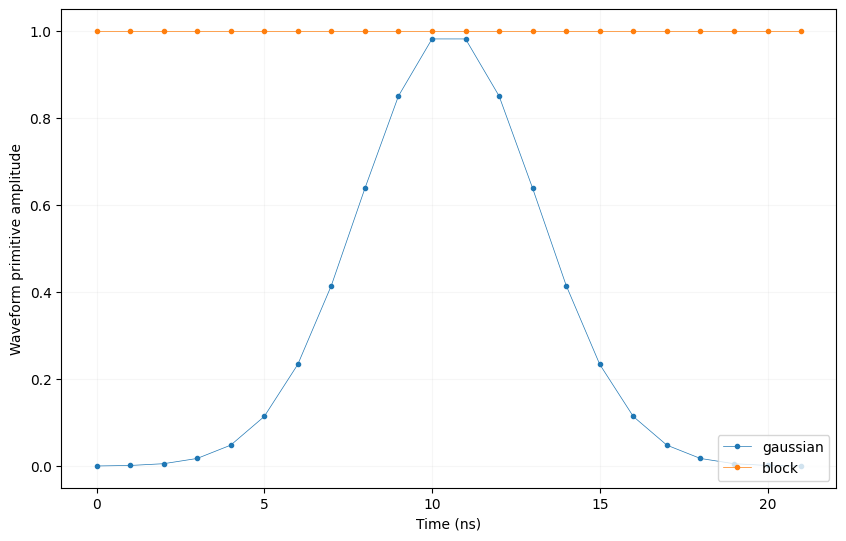

In [38]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

Create Q1ASM program
--------------------

Now that we have the waveforms for the sequence, we need a Q1ASM program that sequences the waveforms as previously described. The Q1ASM program can address the memory in the sequences waveforms and acquisitions to construct a program for playback. View [Q1 Programming](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#instructions) for a break down of available instructions in the Q1ASM language.

In [33]:
# Sequence program.
seq_prog = """
       move      1000000,R0   #Loop iterator.
       move      20,R1    #Initial wait period in ns.
       wait_sync 4        #Wait for sequencers to synchronize and then wait another 4 ns.

loop:  set_mrk   1        #Set marker output 1.
       play      0,1,4    #Play a gaussian and a block on output path 0 and 1 respectively and wait 4 ns.
       set_mrk   0        #Reset marker output 1.
       upd_param 18       #Update parameters and wait the remaining 18 ns of the waveforms.

       wait      R1       #Wait period.

       play      1,0,22   #Play a block and a gaussian on output path 0 and 1 respectively and wait 22 ns.
       wait      1000     #Wait a 1us in between iterations.
       add       R1,20,R1 #Increase wait period by 20 ns.
       loop      R0,@loop #Subtract one from loop iterator.

       # stop               #Stop the sequence after the last iteration.
"""

Prepare and Upload sequence
---------------------------

Now that we have the waveforms and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [34]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [35]:
# Upload sequence.
module.sequencer0.sequence("sequence.json")
module.sequencer1.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers in the instrument to use the `wait_sync` instruction
at the start of the Q1ASM program to synchronize.

In [36]:
# Configure the sequencers to synchronize.
module.sequencer0.sync_en(True)
module.sequencer1.sync_en(True)

# Map sequencers to specific outputs (but first disable all sequencer connections).
module.disconnect_outputs()

# If it is a QRM, we only map sequencer 0 to the outputs.
module.sequencer0.connect_sequencer("out0_1")
if module.is_qcm_type:
    module.sequencer1.connect_sequencer("out2_3")

Now let's start the sequence. If you want to observe the sequence, this is the time to connect an oscilloscope to marker output 1 and one or more
of the four outputs. Configure the oscilloscope to trigger on the marker output 1.

In [37]:
# Arm and start both sequencers.
module.arm_sequencer(0)
module.arm_sequencer(1)
module.start_sequencer()

# Print status of both sequencers.
print(module.get_sequencer_state(0))
print(module.get_sequencer_state(1))

Status: RUNNING, Flags: NONE
Status: RUNNING, Flags: NONE


Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [16]:
# Stop both sequencers.
module.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(module.get_sequencer_state(0))
print(module.get_sequencer_state(1))
print()

# Print an overview of the instrument parameters.
print("Snapshot:")
module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

Status: STOPPED, Flags: FORCED_STOP
Status: STOPPED, Flags: FORCED_STOP

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

Status: OKAY, Flags: NONE, Slot flags: NONE
